In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import scipy.stats as stats
import scipy.integrate as integrate
import pymc3 as pm
from random import choices
import pickle
scale90=stats.norm.interval(.9)[1]
%matplotlib notebook

# Observations of the Last Glacial Maximum
The uncertainty comes from uncertainty in the "true" value of $\Delta T$ and $\Delta F$.  Here, I will model them as the Tierney estimate
$$P_(\Delta T)(\Delta T) \sim \mathcal{N}(-6.1,0.49)$$ 
and the estimate of radiative forcing from the WCRP assessment 
$$P_(\Delta F) (\Delta F) \sim \mathcal{N}(-8.8,2)$$
Moving forward, I believe the best thing to do is to use a hierarchical model for these quantities.  Both the "true" temperature difference and forcing change are unobservable.  Instead, we have an ensemble of reconstructed temperatures and observationally-constrained modeled radiative forcing.  How should we combine these to get a best estimate of LGM temperature and forcing?  I think the best (at least simplest) way to do this is to treat each estimate as drawn from a distribution with unknown mean and standard deviation.  We can put priors on this distribution:
$$\mu | \sigma \sim \mathcal{N}(\mu_0,\sigma/\sqrt{\nu})$$
and
$$\sigma^2 \sim IG(k, 1/\sigma_0^2)$$
The posteriors will therefore depend on our prior beliefs in the "true" underlying value of these quantities: 

In [2]:
def PT(T):
    muT= -6.1
    sigT=(6.5-5.7)/scale90
    #muT=-5.
    #sigT=1.
    return np.exp(-0.5*(T-muT)**2/sigT**2)*1/(np.sqrt(2*np.pi)*sigT)
def PF(F):
    muF=-8.8
    sigF=2.

    #muT=-5.
    #sigT=1.
    return np.exp(-0.5*(F-muF)**2/sigF**2)*1/(np.sqrt(2*np.pi)*sigF)

# Last Glacial Maximum Likelihood
Let's assume (for now) the pattern effect during the last glacial maxiumum is zero (ie, the pattern effect arises only through diseqilibrium) but that there might be state dependence.  In that case, our model for the climate system is 
\begin{equation}
0 = \lambda \Delta T - 2\alpha \Delta T^2 + \Delta F \label{eq}
\end{equation}
and the likelihood is given by the line integral of the joint PDF over this curve:
$$\mathcal{L}(\lambda,\alpha | \Delta T, \Delta F) = \int_C P_{\Delta T}(\Delta T)  P_{\Delta F}(\Delta F) dl$$
which, given the simple model, is eqivalent to
$$\int_{-\infty}^{+\infty}P_{\Delta T}(x) P_{\Delta F}(2\alpha x^2 -\lambda x) \sqrt{1+(4\alpha x-\lambda)^2} dx$$

In [3]:
def LGM_likelihood(lam,alpha):
    
    integrand=lambda x: PF(2*alpha*x**2- lam*x)*PT(x)* np.sqrt(1+(4*alpha*x-lam)**2)

    return integrate.quad(integrand,-np.inf,np.inf)[0]

In [4]:
lams=np.linspace(-5,5,1000)
alphas=np.linspace(-1,1,500)

lamshape=len(lams)
alphashape=len(alphas)



# Prior on $\lambda$
Assume the process evidence gives rise to a prior on $\lambda$:
$$P(\lambda) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left\{-\frac{1}{2}\left(\frac{\lambda-\mu}{\sigma} \right)^2  \right\}$$
with $\mu=-1.3$ and $\sigma = 0.44$ as in the WCRP assessment.

In [5]:
mulam=-1.3
siglam=0.44

proc=np.exp(-0.5*(lams-mulam)**2/siglam**2)*1/(np.sqrt(2*np.pi)*siglam)

# Prior on $\alpha$
This is taken from the WCRP assessment paleo section.  "Most analyses suggest stronger net feedback for glacial
states (i.e., λ more negative, implying a lower sensitivity)."  So the assessment used
$$P(\alpha) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left\{-\frac{1}{2}\left(\frac{\alpha-\mu}{\sigma} \right)^2  \right\}$$
with $\mu=+0.1$ and $\sigma = 0.1$

In [6]:
alphaprior=np.exp(-0.5*(alphas-0.1)**2/0.1**2)*1/(np.sqrt(2*np.pi)*0.1)

# How much does state dependence matter?
Let's calculate the likelihood function for $\lambda$ for the LGM conditional on various values of $\alpha$.

In [7]:
LGM0=np.array([LGM_likelihood(x,0) for x in lams])

LGM01=np.array([LGM_likelihood(x,0.1) for x in lams])

LGM005=np.array([LGM_likelihood(x,0.05) for x in lams])

LGMneg01=np.array([LGM_likelihood(x,-0.1) for x in lams])

max likelihood S, alpha=0 2.690909090909091
max likelihood S, alpha=0.1 1.4827458256029684


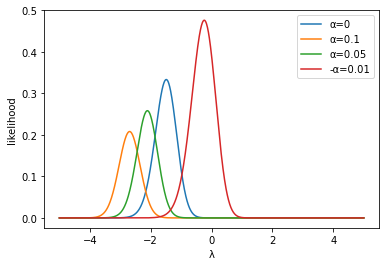

In [70]:
plt.figure()
plt.plot(lams,LGM0,label="α=0")
plt.plot(lams,LGM01,label="α=0.1")
plt.plot(lams,LGM005,label="α=0.05")

plt.plot(lams,LGMneg01,label="-α=0.01")
plt.xlabel("λ")
plt.ylabel("likelihood")
plt.legend()
print("max likelihood S, alpha=0",-4./lams[np.argmax(LGM0)])
print("max likelihood S, alpha=0.1",-4./lams[np.argmax(LGM01)])


## Joint PDF for LGM
Generate the joint likelihood for various values of $\lambda$ and $\alpha$.  Note that these are not samples- we're just integrating the joint PDF for the temperature and forcing changes over the curve defined by the energy balance model with state dependence.

In [19]:
generate_joint_PDF=False
pickle_it=False

if generate_joint_PDF:
    JPDF=np.zeros((lamshape,alphashape))
    for i in range(lamshape):
        for j in range(alphashape):
            JPDF[i,j]=LGM_likelihood(lams[i],alphas[j])
else:
    with open("PICKLED/LGM_JPDF.pkl","rb") as picklefile:
        JPDF=pickle.load(picklefile)

if pickle_it:
    with open("PICKLED/LGM_JPDF.pkl","wb") as picklefile:
        pickle.dump(JPDF,picklefile)

# Uniform priors on all parameters
If we don't know anything about either the feedbacks or the state dependence, large values of alpha are favored.

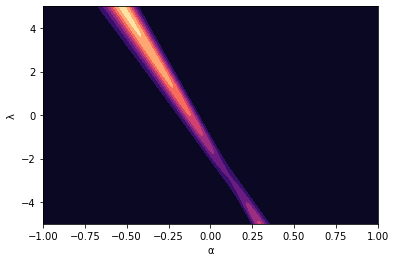

In [76]:
plt.figure()
plt.contourf(alphas,lams,JPDF)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

# Marginal PDF of alpha given the process evidence
If we treat the process evidence as a prior on $\lambda$, what does this tell us about the possible values of the state dependence?  And how does this compare to the priors placed on the state dependence in S20?

The process evidence imposes the same constraints on $\lambda$, regardless of $\alpha$

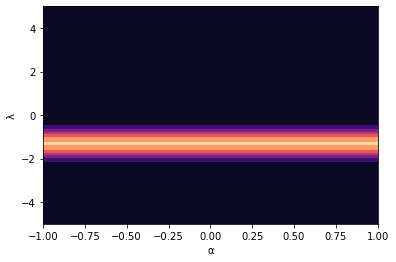

In [44]:
justproc=np.tile(proc,len(alphas)).reshape(len(alphas),len(proc)).T
plt.figure()
plt.contourf(alphas,lams,justproc)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")

Multiplying this by the LGM joint likelihood significantly constrains $\alpha$.

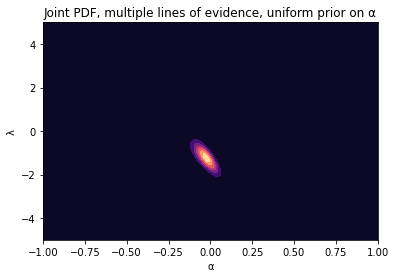

In [78]:
plt.figure()
plt.contourf(alphas,lams,JPDF*justproc)
tmp=plt.xlabel("α")
tmp=plt.ylabel("λ")
tmp=plt.title("Joint PDF, multiple lines of evidence, uniform prior on α")

In S20, we used a Gaussian prior for the state dependence.  This gives a different pdf than the marginal pdf we get by integrating over $\lambda$.

Text(0.5, 0, 'α')

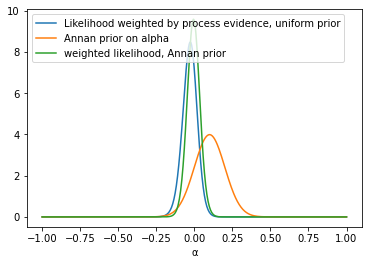

In [79]:
plt.figure()
plt.plot(alphas,np.dot(proc,JPDF)/np.trapz(np.dot(proc,JPDF),x=alphas),label="Likelihood weighted by process evidence, uniform prior")
plt.plot(alphas,alphaprior,label="Annan prior on alpha")
plt.plot(alphas,np.dot(proc,JPDF)*alphaprior/np.trapz(np.dot(proc,JPDF)*alphaprior,x=alphas),label="weighted likelihood, Annan prior")
plt.legend(ncol=1,loc=2)
plt.xlabel("α")

If you literally have no physical idea what the state dependence might be, net positive feebacks and strong state dependence best fit the data.  This is unphysical.

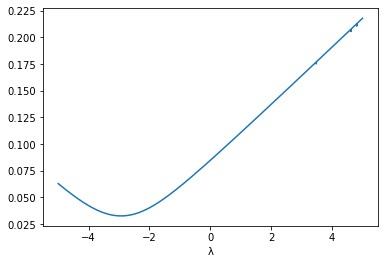

In [47]:
plt.figure()
JPDF_uniformalphanoproc=np.sum(JPDF,axis=1)/np.trapz(np.sum(JPDF,axis=1),x=lams)
plt.figure()
plt.plot(lams,JPDF_uniformalphanoproc)
tmp=plt.xlabel("λ")

This expresses the (very obvious) fact that if you want the LGM to teach you anything, you need to have some sort of constraint on the state dependence $\alpha$.  If your prior treats every value of $\alpha$ as equally likely, the constraint from the LGM will be identical to that from the process evidence.  If, however, you know something (or believe you know something) about what, physically, the state dependence might be, then this allows the LGM evidence to place new additional constrainte on the feedbacks.

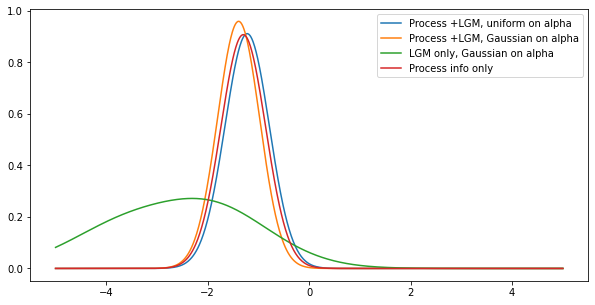

In [96]:
plt.figure(figsize=(10,5))
JPDF_uniformalpha=np.sum(JPDF*justproc,axis=1)/np.trapz(np.sum(JPDF*justproc,axis=1),x=lams)
JPDF_annanalpha=np.dot(JPDF*justproc,alphaprior)/np.trapz(np.dot(JPDF*justproc,alphaprior),x=lams)
JPDF_noproc=np.dot(JPDF,alphaprior)/np.trapz(np.dot(JPDF,alphaprior),x=lams)

plt.plot(lams,JPDF_uniformalpha,label="Process +LGM, uniform on alpha")
plt.plot(lams,JPDF_annanalpha,label="Process +LGM, Gaussian on alpha")
plt.plot(lams,JPDF_noproc,label="LGM only, Gaussian on alpha")
#plt.plot(lams,tst/np.trapz(tst,x=lams),label="alpha=0,no process information")
plt.plot(lams,proc,label="Process info only")
plt.legend(ncol=1)

# History
## Observations
Using Bellouin aerosol forcing as calculated by Piers and Mark for (Sherwood et al, 2020).

In [98]:
def bellouin_ringberg_stats_fix_200311_ERFaer(nsamples):
#From WCRP code downloaded 3/10
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import math

    # Distribution type
    # u - uniform, but arguments are 16th and 84th percentile
    #       assumes uniform outside these values (no very large values)
    # v - uniform, next two arguments are upper and lower bounds
    # c - constant value
    # n - normal distribution with bounds as 2 sigma width around an average mean

    d = {}
    d['rsdt'] =          ['c', -340]

    # Aerosol variables
    d['dtau'] =          ['u', 0.02,   0.04]
    d['tau'] =           ['u', 0.13,   0.17]

    # RFari terms
    d['S_tau'] =         ['u', -20,   -27]
    d['RFari_cloudy'] =  ['u', -0.1, 0.1 ]

    # RAari
    d['dR_dRatm'] =      ['u', -0.1, -0.3]
    d['dRatm_dtau'] =    ['u', 17,     35]

    # Cloud fractions
    d['c_tau'] =         ['u', 0.59,  0.71]
    d['c_N'] =           ['u', 0.19,  0.29]
    d['c_L'] =           ['u', 0.21, 0.29 ]
    d['c_C'] =           ['u', 0.59, 1.07 ]         

    # Nd sensitivity to aerosol, and adjustment terms
    d['beta_N_tau'] =   ['u', 0.3,    0.8]
    d['beta_L_N'] =     ['u', -0.36,  -0.011] 
    d['beta_C_N'] =       ['u', 0,      0.1]

    # Cloud albedo terms
    d['S_N'] =           ['u', -26,    -27]
    d['S_L'] =           ['u', -54,    -56]
    d['S_C'] =           ['u', -91,   -153]


    ############################################
    # Create the distributions and store in ds #
    ############################################

    ds = {}
    for name in d.keys():
      if d[name][0] == 'c':
          ds[name] = d[name][1]
      elif d[name][0] == 'u':
          diff = 16*(d[name][2]-d[name][1])/(84-16)
          ds[name] = np.random.uniform(d[name][1]-diff, d[name][2]+diff, nsamples)
      elif d[name][0] == 'v':
          ds[name] = np.random.uniform(d[name][1], d[name][2], nsamples)
      elif d[name][0] == 'n':
          cent = (d[name][2]+d[name][1])/2
          spread = (d[name][2]-d[name][1])/2
          ds[name] = np.random.uniform(cent, spread, nsamples)

    ############################
    # The Ringberg Equation!!! #
    ############################
    rfari = ds['dtau']*ds['S_tau']*(1-ds['c_tau'])+ds['RFari_cloudy']
    rfari_adj = ds['dtau']*ds['dR_dRatm']*ds['dRatm_dtau']

    ds['dlntau'] = ds['dtau']/ds['tau']
    deltan = ds['dlntau']*ds['beta_N_tau']

    rfaci = ds['dlntau']*ds['beta_N_tau']*ds['S_N']*ds['c_N']
    erfaci_L = ds['dlntau']*ds['beta_N_tau']*ds['beta_L_N']*ds['S_L']*ds['c_L']
    erfaci_C = ds['dlntau']*ds['beta_N_tau']*ds['beta_C_N']*ds['S_C']*ds['c_C']

    ERFaer=rfari+rfari_adj+rfaci+erfaci_L+erfaci_C
    return ERFaer

def read_hist_forc(hist_forcing_version='Bellouin_2020_eqn_8',\
                   alternative_pi_period=False,
                  period_1850_2005_2015=False,\
                  period_1750_2018=False):
    inpath = "WCRP_ECS_assessment_code_200714/"
    #start by making the forcing according to Piers' code and commentary

    #note the only edit I made to his files is to make the col names automatically readable for the 2nd one (ie removing spaces)

    # Piers Forster's code retained in comments marked PF 
    # James Annan's code retained in comments marked JDA



    # Read in data

    from io import StringIO   # StringIO behaves like a file object
    #from google.colab import drive
    #drive.mount('/content/gdrive')

    # **** Read in historical forcing upper, mid and lower ranges ****

    if hist_forcing_version == 'Bellouin_2020_eqn_8':
        hist_forcing_ranges='WCRP_forcing_ranges_200311.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'Bellouin_2020_constrained':
        hist_forcing_ranges='WCRP_forcing_ranges_Bellouinaerosol_constrained_200321.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_Bellouinaerosol2.csv'

    if hist_forcing_version == 'AR5_extended':
        hist_forcing_ranges='IPCCAR5_forcing_ranges_200320.csv'
        hist_monthly_forcings='Forster_forcings_2018_WCRP_AR5aerosol_200320.csv'

    best_upper_lower = pd.read_csv(inpath+hist_forcing_ranges,nrows=3)

    best=best_upper_lower.iloc[0]
    lower=best_upper_lower.iloc[1]
    upper=best_upper_lower.iloc[2]

    # PF ; assumes 90% are 1.65 sigma
    # PF sdlower=(best-lower)/1.65
    # PF sdupper=(upper-best)/1.65

    # MJW calulate standard deviations which would give lower and upper values as 5-95% ranges
    # assumes 90% are 1.64 sigma
    sdlower=(best-lower)/1.64
    sdupper=(upper-best)/1.64

    

    # **** Read in AR5 annual mean forcing data ****

    df=pd.read_csv(inpath+hist_monthly_forcings,delimiter=',',skiprows=19)

    #print (forc_table["Year/month"]
    df = df.set_index(['Year/month']) 

    df_baseline=df.loc[1861:1880]
    #df_recent=df.loc[2002:2017]
    df_recent=df.loc[2006:2018] # updated 16/3/20

    if alternative_pi_period:
        df_baseline=df.loc[1850:1900]

    if period_1850_2005_2015:
        df_baseline=df.loc[[1850,1850]]
        df_recent=df.loc[2005:2015]

    if period_1750_2018:
        df_baseline=df.loc[[1750,1750]]
        df_recent=df.loc[[2018,2018]]

   # print (df_baseline)
   # print (df_recent)

    # JDA: CO2 forcing is based on F2x so I will back-calculate the doubling fraction from this
    #
    # JDA: now generate a sample of all the other forcings

    uncs_neg = ( best - lower ) / (1.64 * best )
    uncs_pos = ( upper - best ) / (1.64 * best )

    return (df_recent,df_baseline,uncs_neg,uncs_pos)

def get_total_forcing(nsamp):
    #Aerosol forcing is different- median is -1.1, not -1.179
    df_recent,df_baseline,uncs_neg,uncs_pos=read_hist_forc()

   
    labels = ['Other WMGHG','O3 (T)','O3(S)','ERF LUC','Vapour','BC snow','contrails','Solar','Volcanic',"total aerosol ERF"] 
    f_other = np.zeros(nsamp)
    devs = np.random.normal(loc=0.0, scale=1.0, size=nsamp)
    for label in labels:
        baseline=df_baseline[label].to_numpy()
        baseline=np.mean(baseline)

        recent=df_recent[label].to_numpy()
        recent=np.mean(recent)

        if label != "total aerosol ERF":

            devscaled = (devs >= 0) * devs * uncs_pos[label] 
            devscaled = devscaled + (devs < 0) * devs * uncs_neg[label]
            f_component = (recent - baseline) * (1+devscaled)
            f_other=f_other+f_component
        else:
            #aerosols
            ERFaer = bellouin_ringberg_stats_fix_200311_ERFaer(nsamp)
            #devscaled=ERFaer/np.median(ERFaer)-1.0
            # rescale by the factor that reproduces Bellouin et al 2020 PDF between 1850 and 2005-2015
            peak_ERFaer=-0.87
            devscaled=ERFaer/peak_ERFaer-1.0
            #print(recent-baseline)
            total_aerosol_forcing=(recent - baseline) * (1+devscaled)
            #print("Aerosol 5-95 range",np.percentile(total_aerosol_forcing,5),np.percentile(total_aerosol_forcing,95))
            #print("aserosol median",np.median(total_aerosol_forcing))


    #CO2
    label='CO2'
    baseline=df_baseline[label].to_numpy()
    baseline=np.mean(baseline)

    recent=df_recent[label].to_numpy()
    recent=np.mean(recent)

    CO2_hist_mean = (recent - baseline)

    F2x=4.
    F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    CO2_hist=CO2_hist_mean*F2x/np.mean(F2x)

    tot_f=f_other+total_aerosol_forcing+CO2_hist
    return tot_f


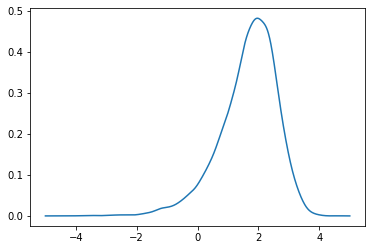

In [103]:
plt.figure()
dF_obs=get_total_forcing(10000)
#tmp=plt.hist(dF_obs,100,density=True)
x=np.linspace(-5,5,1000)
forcing_prob=stats.gaussian_kde(dF_obs)
plt.plot(x,forcing_prob(x))

## Other observations


Temperature and imbalance estimates taken from Table 5 of (Sherwood et al 2020); 5-95% confidence levels converted into $\sigma$ using normal distribution

$\Delta T \sim \mathcal{N}(1.03,0.085)$

$\Delta N \sim \mathcal{N}(0.6,0.18)$

In [106]:
nsamp=1000
scale90=stats.norm.interval(.9)[1]

dF_obs=get_total_forcing(nsamp)
dT_obs=np.random.normal(1.03,(.17-.03)/scale90,nsamp)
dN_obs=np.random.normal(.6,0.3/scale90,nsamp)

x=dN_obs-dT_obs

F2x=4.
F2x_error=np.random.normal(F2x,0.49/1.64,size=nsamp)
    

Calculate a kernel density estimate from these samples (do this numerically since we don't have a functional form for $\Delta F$)

In [107]:
test_values=np.zeros((3,nsamp))
test_values[0]=dT_obs
test_values[1]=dF_obs
test_values[2]=dN_obs


test_kde=stats.gaussian_kde(test_values)

The simplest energy balance model is 

$\Delta N = \lambda \Delta T + \Delta F$

This is deterministic: if we knew the "true" values of the imbalance, temperature change, and forcing, we'd know the feedback parameter exactly.  That is: there is no randomness in $\lambda$ or uncertainty in this model: the uncertainty in $\lambda$ is completely due to the uncertainty in the observations. 

(Aside: if we consider shorter-term observations, we have to consider internal variability.  In that case, the model is $$\Delta N = \lambda \Delta T + \Delta F+V$$ and we have to consider a further hierarchical step 
$$\lambda_{obs} \sim \mathcal{N}(\lambda_{true},\sigma_V^2)$$ where we assume the observed values of $\lambda$ are normally distributed about the "true" (latent) feedback parameter and $\sigma_V^2$ represents the scatter due to internal variability of the climate system.  But let's not get ahead of ourselves.)

This model defines a plane in $(\Delta T, \Delta N, \Delta F)$ space.

Intuitively, the likelihood of the observed evidence given a value of $\lambda$ depends on the intersection of the plane defined by $\lambda$ and the joint PDF of the observations.  A plane that cuts through a large section of the PDF corresponds to a high likelihood of the evidence given that particular $\lambda$, while a plane that just grazes the side corresponds to a low likelihood.  This is a 3D generalization of the method used in Sherwood et al for the historical section.

<IPython.core.display.Javascript object>


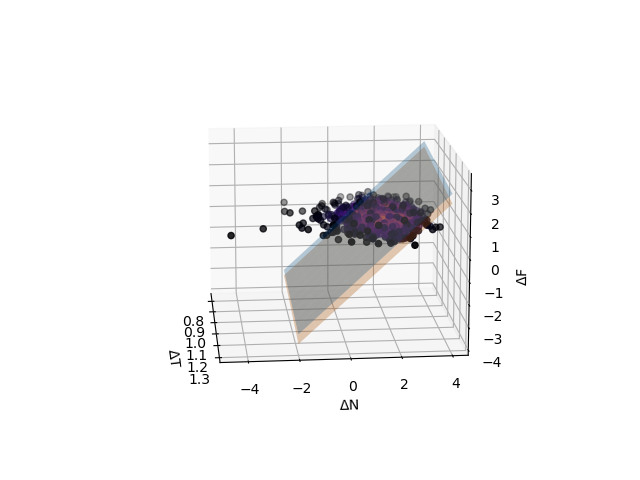

In [132]:
def plot_plane_lam(lam,ax):
    Ts = np.linspace(.8,1.3,int(nsamp/100))
    Fs = np.linspace(-2,4.0,int(nsamp/100))
    xx,yy=np.meshgrid(Ts,Fs)
    #zz = -1/lam*(xx-yy)
    zz = lam*xx+yy
    ax.plot_surface(xx,yy,zz,alpha=.3,label="lam = "+str(lam))

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
plt.set_cmap(cm.magma)
ax.scatter(test_values[0], test_values[1], test_values[2], c=test_kde(test_values))
tmp=ax.set_xlabel(r'$\Delta$T')
tmp=ax.set_ylabel(r'$\Delta$N')
tmp=ax.set_zlabel(r'$\Delta$F')

#plot_plane_lam(0,ax=ax)
plot_plane_lam(-1,ax=ax)
plot_plane_lam(-1.33,ax=ax)
plt.show()

Define the likelihood as the surface integral of the joint PDF of observations over the plane defined by $\lambda$:

$$\int \int PDF(\Delta T, \Delta F, \Delta N) dS = \int \int PDF( \vec{r}(u,v) )|| r_u \times r_v|| dA$$
where 
$$\vec{r} =u \hat{i} + v \hat{j} + (\lambda u+ v)\hat{k}$$
If the observations $\Delta T, \Delta F, \Delta N$ are all independent and normally distributed, we can write this integral in terms of Gaussians and get a nice analytic functional form.  This is moot because $\Delta F$ is not normally distributed.  So let's do it numerically:

In [ ]:
#Functional form of the likelihood P(evidence | λ)
#This takes longer than I'd like, but maybe we can fit a spline to a bunch of samples to make it go faster
def likelihood_density_lambda(λ,Δλ,tmin=-10,tmax=10,qmin=-10,qmax=10):
    ru=np.array([1,0,λ-Δλ])
    rv=np.array([0,1,1])
    jacobian=np.linalg.norm(np.cross(ru,rv))
    func=lambda u,v: test_kde((u,v,(λ-Δλ)*u+v))*jacobian
    return integrate.dblquad(func,tmin,tmax,lambda u: qmin, lambda u: qmax)[0]

In [116]:

pickle_historical=False
if pickle_historical:
    lam_hist=[]
    lams=np.linspace(-5,5,1000)
    for lam in lams:
        lam_hist+=[likelihood_density_lambda(lam,0,tmin=-np.inf,tmax=np.inf,qmin=-np.inf,qmax=np.inf)]
    import pickle
    with open("PICKLED/lam_hist0512.dat","wb") as picklefile:
        pickle.dump(np.array(lam_hist),picklefile)
else:
    with open("PICKLED/lam_hist0512.dat","rb") as picklefile:
        lam_hist=pickle.load(picklefile)


<IPython.core.display.Javascript object>


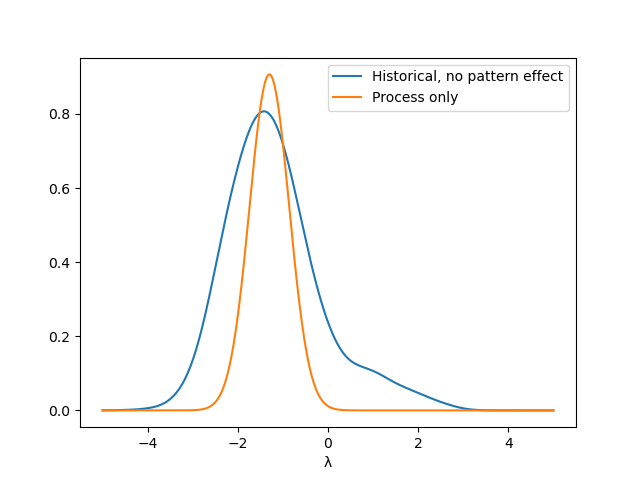

Text(0.5, 0, 'λ')

In [120]:
plt.figure()
plt.plot(lams,lam_hist,label="Historical, no pattern effect")
plt.plot(lams,proc,label="Process only")
plt.legend()
plt.xlabel("λ")

In [28]:
#retrofit with pattern effect
pattern = np.linspace(-1,1,500)
patternshape=len(pattern)
histJPDF=np.zeros((lamshape,patternshape))
for i in range(lamshape):
    for j in range(patternshape):
        lamtest=lams[i]
        patttest=pattern[j]
        tot_lam=lamtest-patttest
        if np.abs(tot_lam)>=5.:
            lik=0.
        else:
            lik=lam_hist[np.argmin(np.abs(lams-tot_lam))  ]
        histJPDF[i,j]=lik

<IPython.core.display.Javascript object>


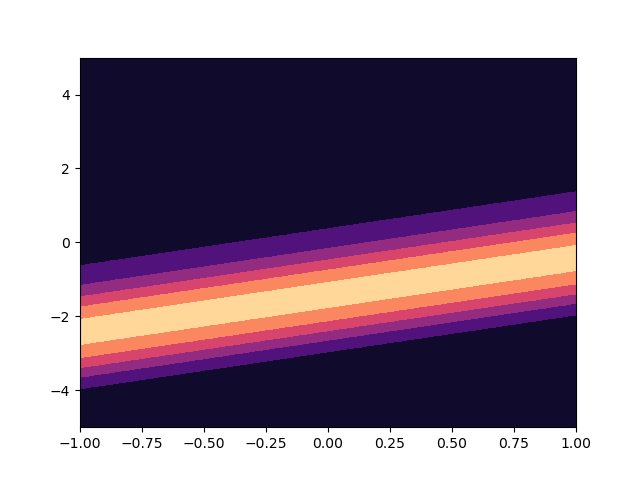

In [133]:
plt.figure()
plt.set_cmap(cm.magma)
plt.contourf(pattern,lams,histJPDF)

## Prior on $\Delta \lambda$
Assume, as in S20, a Gaussian prior on the pattern effect

In [124]:
patternsigma=0.4/scale90
patternprior=np.exp(-0.5*(pattern-0.2)**2/patternsigma**2)*1/(np.sqrt(2*np.pi)*patternsigma)

The effect of this prior is to shift the PDF for $\lambda$ (marginalized over $\Delta \lambda$ ) to less negative feedbacks -> higher climate sensitivities

<IPython.core.display.Javascript object>


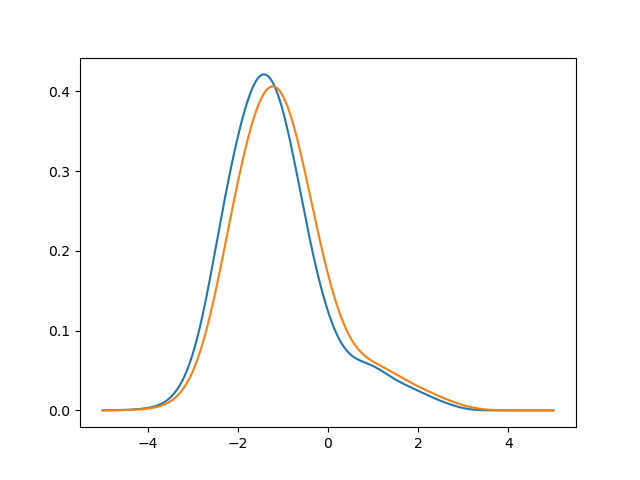

In [135]:
plt.figure()
plt.plot(lams,lam_hist/np.trapz(lam_hist,x=lams),label="Historical, no pattern effect")
histpriortest=np.dot(histJPDF,patternprior)/np.trapz(np.dot(histJPDF,patternprior),x=lams)
plt.plot(lams,histpriortest)

<IPython.core.display.Javascript object>


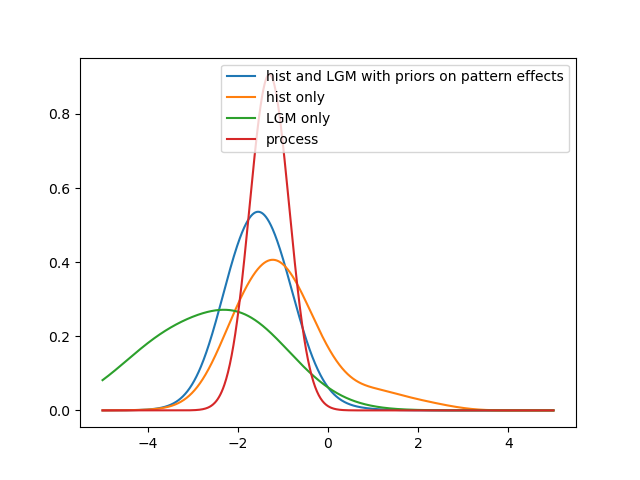

In [130]:
#plt.plot(lams,np.dot(histJPDF,patternprior)/np.trapz(np.dot(histJPDF,patternprior),x=lams))
#plt.plot(lams,np.dot(JPDF,alphaprior)/np.trapz(np.dot(JPDF,alphaprior),x=lams))
plt.figure()

lgmpriortest=np.dot(JPDF,alphaprior)/np.trapz(np.dot(JPDF,alphaprior),x=lams)
hist_and_LGM=histpriortest*lgmpriortest/np.trapz(histpriortest*lgmpriortest,x=lams)
plt.plot(lams,hist_and_LGM,label="hist and LGM with priors on pattern effects")
plt.plot(lams,histpriortest,label="hist only")
plt.plot(lams,lgmpriortest,label="LGM only")
plt.plot(lams,proc,label="process")
plt.legend()
#plt.plot(lams,lam_hist/np.trapz(lam_hist,x=lams))

In [39]:
histJPDF_gauss=np.dot(histJPDF*justproc,patternprior)/np.trapz(np.dot(histJPDF*justproc,patternprior),x=lams)


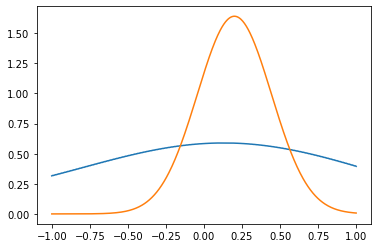

In [38]:
plt.plot(pattern,np.dot(proc,histJPDF)/np.trapz(np.dot(proc,histJPDF),x=pattern),label="weighted likelihood, uniform prior")
plt.plot(pattern,patternprior)

<IPython.core.display.Javascript object>


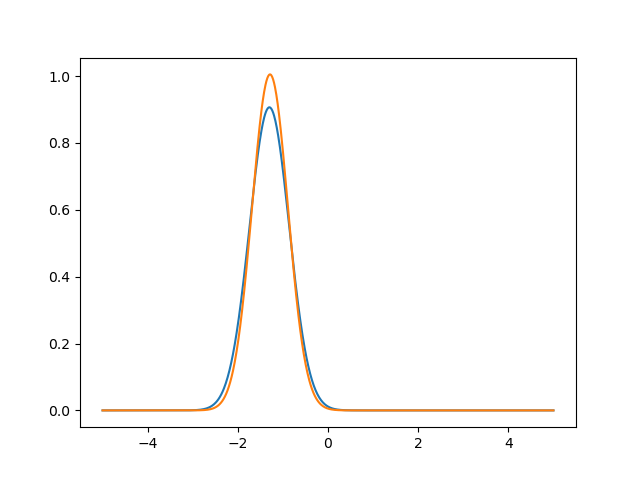

In [127]:
#plt.plot(lams,lam_hist)
#plt.plot(lams,JPDF_annanalpha,label="Process +LGM, Gaussian on alpha")
#plt.plot(lams,tst/np.trapz(tst,x=lams),label="alpha=0,no process information")
plt.figure()
plt.plot(lams,proc,label="Process info only")
plt.plot(lams,histJPDF_gauss)
#plt.plot(lams,proc*lam_hist,label="both")

In [ ]:
#what if we don't have process evidence?
#what kind of constraints do 

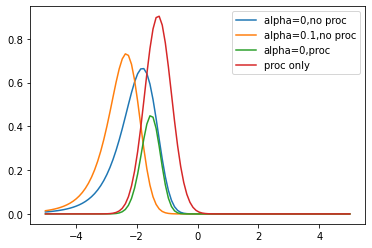

In [53]:
plt.plot(lams,tst/np.trapz(tst,x=lams),label="alpha=0,no proc")
plt.plot(lams,tst01/np.trapz(tst01,x=lams),label="alpha=0.1,no proc")
plt.plot(lams,tst/np.trapz(tst,x=lams)*proc,label="alpha=0,proc")
plt.plot(lams,proc,label="proc only")
plt.legend()

Text(0, 0.5, 'λ')

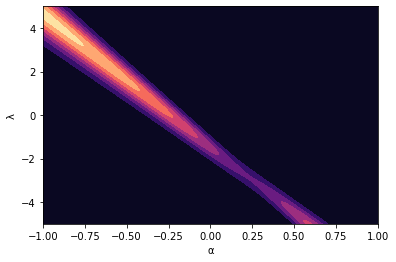

In [117]:
plt.figure()
plt.contourf(alphas,lams,JPDF)
plt.xlabel("α")
plt.ylabel("λ")

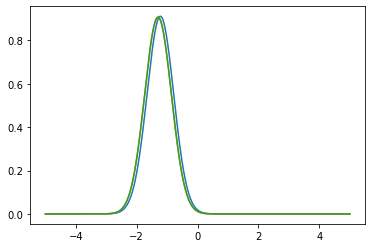

In [118]:
plt.plot(lams,np.sum(JPDF*justproc,axis=1)/np.trapz(np.sum(JPDF*justproc,axis=1),x=lams))
plt.plot(lams,np.sum(justproc,axis=1)/np.trapz(np.sum(justproc,axis=1),x=lams))
plt.plot(lams,proc)

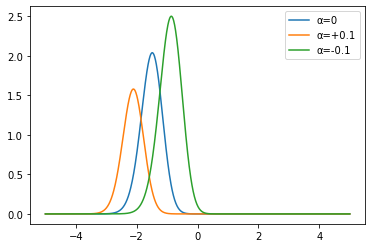

In [119]:
plt.figure()
plt.plot( lams,tst,label="α=0")
plt.plot( lams,tst01,label="α=+0.1")
plt.plot( lams,tstneg01,label="α=-0.1")
plt.legend()

<IPython.core.display.Javascript object>


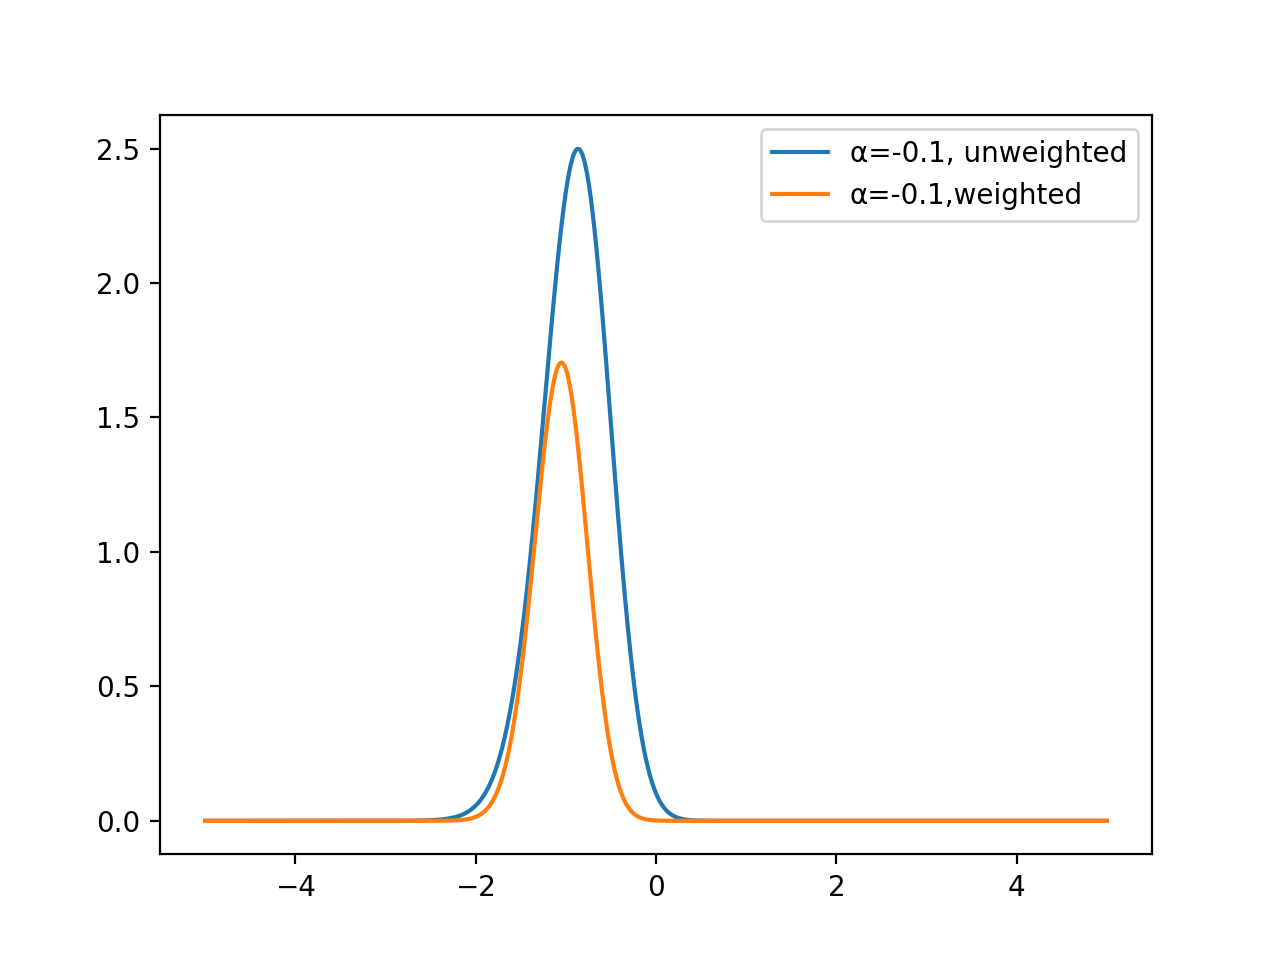

In [71]:
plt.figure()
plt.plot( lams,tstneg01,label="α=-0.1, unweighted")
plt.plot( lams,tstneg01*proc,label="α=-0.1,weighted")
plt.legend()

In [91]:
import seaborn as sns


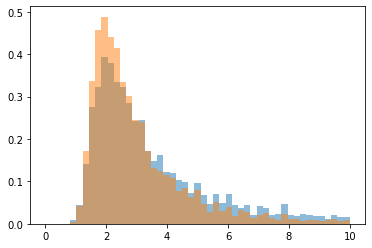

In [89]:
lam_hist_samps=np.random.choice(lams,size=10000,p=histpriortest/np.sum(histpriortest))
lam_both_samps=np.random.choice(lams,size=10000,p=hist_and_LGM/np.sum(hist_and_LGM))
tmp=plt.hist(-4./lam_hist_samps,bins=np.linspace(0,10,50),density=True,alpha=0.5)
tmp=plt.hist(-4./lam_both_samps,bins=np.linspace(0,10,50),density=True,alpha=0.5)



In [74]:
print("Max likelihood S, unweighted",-4./lams[np.argmax(tstneg01)])
print("Max likelihood S, weighted",-4./lams[np.argmax(tstneg01*proc)])

Max likelihood S, unweighted 4.619653179190753
Max likelihood S, weighted 3.823923444976076


In [75]:
print("Max likelihood S, unweighted",-4./lams[np.argmax(tst)])
print("Max likelihood S, weighted",-4./lams[np.argmax(tst*proc)])

Max likelihood S, unweighted 2.690909090909091
Max likelihood S, weighted 2.824028268551237


The process constraints on $\lambda$ downweight positive values of alpha

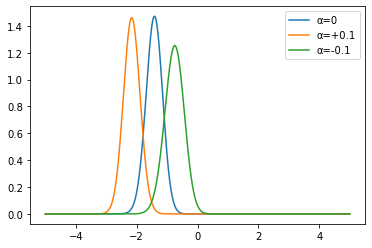

In [70]:
plt.figure()
plt.plot(lams,LGM0*proc/np.trapz(LGM0*proc,x=lams),label="α=0")
plt.plot( lams,LGM01*proc/np.trapz(LGM01*proc,x=lams),label="α=+0.1")
plt.plot(lams,LGMneg01*proc/np.trapz(LGMneg01*proc,x=lams),label="α=-0.1")
plt.legend()

<IPython.core.display.Javascript object>


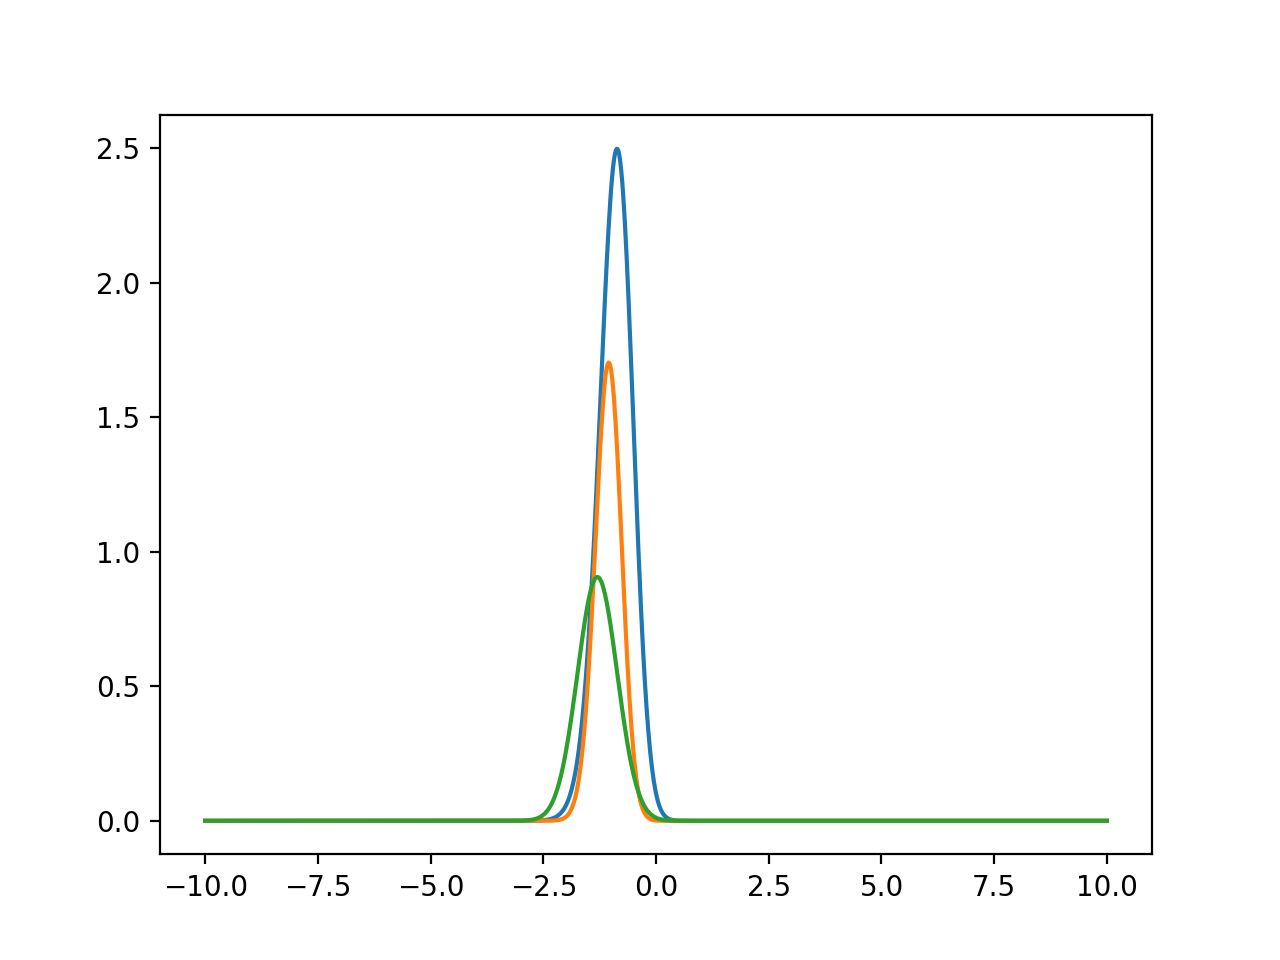

In [52]:
plt.figure()
plt.plot(lams,tstneg01)
plt.plot(lams,tstneg01*proc)
plt.plot(lams,proc)

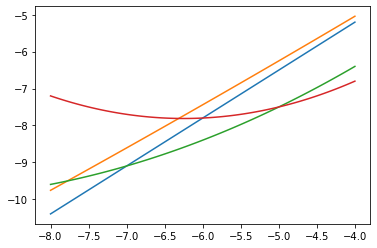

In [86]:
dF=np.linspace(-12,-6,100)
dT=np.linspace(-8,-4,100)
plt.plot(dT,+1.3*dT)
plt.plot(dT,0.01*dT**2+1.3*dT)
plt.plot(dT,0.1*dT**2+2*dT)
plt.plot(dT,0.2*dT**2+2.5*dT)